# Network Intrusion Detection using Deep Learning

### Computer Science Final Year Project by Shreya Agarwal

The following is the code implemented to create my project. There is a separate report which covers various sections such as introduction, literature review, design, implementation, evaluation and conclusion. Therefore, in this code we won't go in detail for those sections and only focus on the code functionality.

# INTRODUCTION

As the modern world is making use of technology everywhere, issues of cyber threat have been persistent. Cyber attacks can lead to data loss and cause users extreme harm and therefore intrusion detection systems(IDS) have been developed over the years to curbe this issue. Below is a code that uses concepts of Machine Learning and Neural Networks to develop such a system.

# IMPLEMENTATION 

We are going to perform CNN and LSTM binary classification using cross validation on the UNSW-NB15 dataset. This dataset has been downloaded from https://research.unsw.edu.au/projects/unsw-nb15-dataset in the form of a csv file. Since the website contains multiple csv files accounting to 2 million plus network data, for the scope of our project we have only downloaded once csv file. The dataset consists information about network traffic data in the form of features such as duration, prototype, servive domain, state, port address, attack type amongst many others.

In [34]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import auc, roc_curve, roc_auc_score

import random 
%matplotlib inline

## Importing Dataset

In [35]:
# Load data
data = pd.read_csv('C:/Users/SHREYA AGARWAL/Downloads/UNSW_NB15.csv')
pd.set_option('display.max_columns', None)
#Display data
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [37]:
data.describe(include='all')

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,175341.000000,175341.000000,175341,175341,175341,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341,175341.000000
unique,NaN,NaN,133,13,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,79946,94168,82275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56000,NaN
mean,87671.000000,1.359389,NaN,NaN,NaN,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,NaN,0.680622
std,50616.731112,6.480249,NaN,NaN,NaN,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,NaN,0.466237
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,43836.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,87671.000000,0.001582,NaN,NaN,NaN,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,131506.000000,0.668069,NaN,NaN,NaN,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065

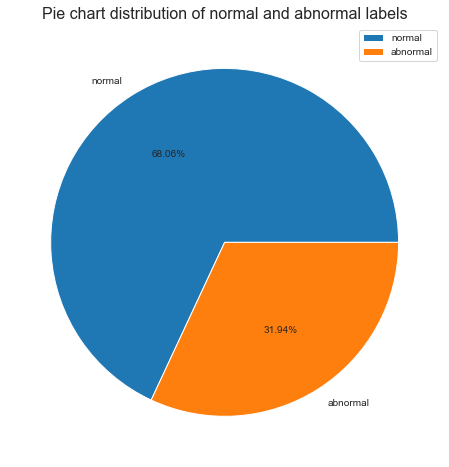

In [38]:
#For binary classification, pie chart is plotted to observe ditsribution of normal vs abnormal data
plt.figure(figsize=(8,8))
plt.pie(data.label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

The chart displays that the dataset contains 68.06% of normal data while the 31.94% is abnormal/attack data.

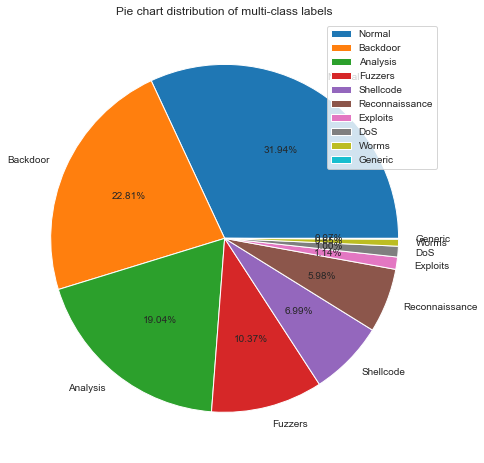

In [39]:
#For multi classification, pie chart is plotted to observe ditsribution of various kinds of attack
plt.figure(figsize=(8,8))
plt.pie(data.attack_cat.value_counts(),labels=data.attack_cat.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
plt.show()

The chart displays that while 31.94% of data is normal, in terms of attack, Backdoor is leading with 22.81% followed by analysis and others.

## Data Cleaning and Pre-processing


In [40]:
#remove unwanted features
dropList = ['id','attack_cat']
data.drop(dropList,axis=1,inplace=True)

# Clamping the extreme values to reduce skewness
data_num = data.select_dtypes(include=[np.number])
data_num.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [41]:
DEBUG =0

for feature in data_num.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(data_num[feature].max()))
        print('75th = '+str(data_num[feature].quantile(0.95)))
        print('median = '+str(data_num[feature].median()))
        print(data_num[feature].max()>10*data_num[feature].median())
        print('----------------------------------------------------')
    if data_num[feature].max()>10*data_num[feature].median() and data_num[feature].max()>10 :
        data[feature] = np.where(data[feature]<data[feature].quantile(0.95), data[feature], data[feature].quantile(0.95))

In [42]:
data_num = data.select_dtypes(include=[np.number])
data_num.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,0.467065,12.617323,10.006792,1697.289989,3648.210481,80957.198684,179.546997,79.609567,5.327025e+07,3.654831e+05,2.154630,3.029765,37.149345,29.464980,1682.831478,252.900753,116.257339,9.571385e+08,9.568256e+08,115.013625,0.041396,0.021020,0.020375,122.279478,112.609065,0.101745,9.849391,9.084264,1.304179,5.793283,4.903263,4.145226,8.505609,0.014948,0.014948,0.101745,6.624788,8.882760,0.015752,0.680622
std,0.816099,17.574046,16.840623,3266.805316,9675.446827,108507.397039,102.940011,110.506863,7.771134e+07,1.011632e+06,3.293608,6.159003,64.856251,49.122669,2824.169851,717.301377,127.001024,1.328074e+09,1.326927e+09,126.886530,0.079354,0.043400,0.040506,143.490588,215.656329,0.302313,38.245594,10.088830,0.954406,6.791916,6.544978,5.589185,10.339146,0.126048,0.126048,0.302313,7.307812,10.154088,0.124516,0.466237
min,0.000000,1.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,114.000000,0.000000,32.786140,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,430.000000,164.000000,3225.806520,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.668069,12.000000,10.000000,1418.000000,1102.000000,125000.000300,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2513.295019,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,3.079511,64.000000,62.000000,13662.000000,39076.000000,333333.321500,255.000000,254.000000,2.666667e+08,4.071050e+06,12.000000,24.000000,245.212857,160.491672,9505.475298,3054.771518,255.000000,3.814196e+09,3.813017e+09,255.000000,2.518893,2.100352,1.520884,638.000000,786.000000,1.000000,166.000000,33.000000,6.000000,24.000000,22.000000,17.000000,33.000000,4.000000,4.000000,1.000000,26.000000,33.000000,1.000000,1.000000


In [43]:
#Reducing cardinality in categorical features
data_cat = data.select_dtypes(exclude=[np.number])
data_cat.describe(include='all')

,proto,service,state
count,175341,175341,175341
unique,133,13,9
top,tcp,-,INT
freq,79946,94168,82275


In [44]:
DEBUG = 0
for feature in data_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(data_cat[feature].nunique()))
        print(data_cat[feature].nunique()>6)
        print(sum(data[feature].isin(data[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if data_cat[feature].nunique()>6:
        data[feature] = np.where(data[feature].isin(data[feature].value_counts().head().index), data[feature], '-')

In [45]:
data_cat = data.select_dtypes(exclude=[np.number])
data_cat.describe(include='all')

,proto,service,state
count,175341,175341,175341
unique,6,5,6
top,tcp,-,INT
freq,79946,100270,82275


In [46]:
#One-hot encoding for the categorical features
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

feature_names = list(X.columns)
np.shape(X)

(175341, 42)

In [47]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
np.shape(X)

(175341, 56)

In [48]:
data_cat.describe(include='all')

,proto,service,state
count,175341,175341,175341
unique,6,5,6
top,tcp,-,INT
freq,79946,100270,82275


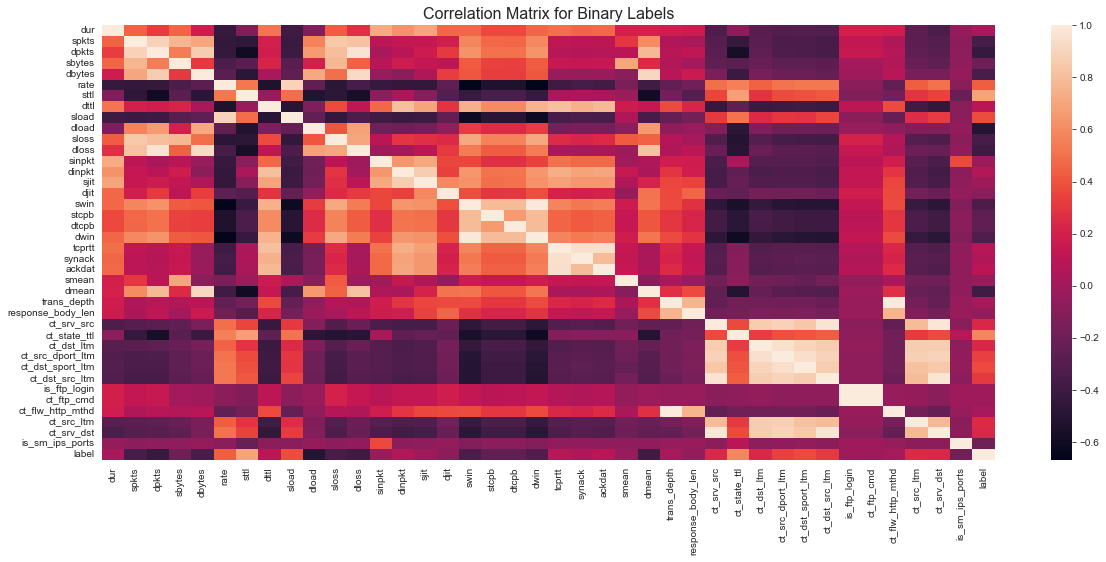

In [49]:
# Computing the correlation matrix for all features
corr_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
plt.show()

In [50]:
len(feature_names)

42

In [51]:
#Binary labelling for categorical features
for label in list(data_cat['state'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(data_cat['service'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)
    
for label in list(data_cat['proto'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)

In [52]:
len(feature_names)

56

In [53]:
#Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)

In [54]:
data_cat.describe(include='all')

,proto,service,state
count,175341,175341,175341
unique,6,5,6
top,tcp,-,INT
freq,79946,100270,82275


In [55]:
# 6+5+6 = 17, which is the number of categorically encoded
#Scaling from 18th row
ss = StandardScaler()
X_train[:, 18:] = ss.fit_transform(X_train[:, 18:])
X_test[:, 18:] = ss.transform(X_test[:, 18:])

## Prototype - baseline model 


In [56]:
#Performing Logistic Regression
baseline_model_perf = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score'])

In [57]:
%%time
start = time.time()
baseline_model = LogisticRegression().fit(X_train,y_train)
end_train = time.time()
y_pred = baseline_model.predict(X_test) # These are the predictions from the test data.
end_pred = time.time()

Wall time: 2.16 s


In [58]:
#Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1s = f1_score(y_test, y_pred, average='weighted')

#Printing the report
print("Accuracy is : "+ "{:.2%}".format(accuracy))
print("Precision is : "+ "{:.2%}".format(precision))
print("Recall is : "+ "{:.2%}".format(recall))
print("F1-Score is : "+ "{:.2%}".format(f1s))
baseline_model_perf.loc['Logistic'] = [accuracy, recall, precision, f1s]

Accuracy is : 93.69%
Precision is : 93.84%
Recall is : 93.69%
F1-Score is : 93.57%


This shows that our baseline model has high accuracy, precision, recall and f1-score indicating that the model is performing really well by correctly identifying the positive instances and minimizing the false positives. This shows that the model is able to detect on unseen data whether the network traffic is normal or malicious.

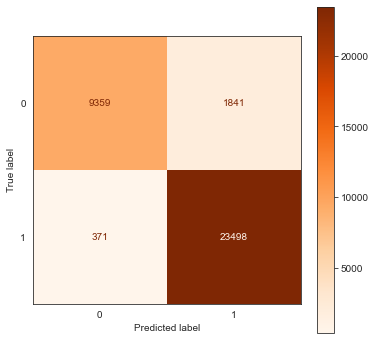

In [26]:
#Plotting confusion matrix for baseline model
plt.rcParams['figure.figsize']=6,6 
sns.set_style("white")
plot_confusion_matrix(baseline_model, X_test, y_test, cmap=plt.cm.Oranges)  
plt.show()

This baseline model will be considered as the threshold based on which the other models performance would be compared and if they achieve better accuracy than the baseline model, they are successful. For the main purpose of our project, first we have implemented an LSTM model which uses cross validation and then a CNN model using cross validation. Each of these models have been experimented and tested on multiple times using hyper-parameter tuning until desired outcome was achieved. The below codes display the final model implemented and their own classification reports.

## LSTM using stratified K-fold evaluation

In [27]:
#This is the main code for building the LSTM model

#Setting seed
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# LSTM model is implemented using various features including input and dense layers
def build_lstm_model(input_shape):
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    lstm_model.add(LSTM(32, return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))  #Using 'sigmoid' for binary classification
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

# Reshaping the input data for LSTM
X_reshaped = X.reshape(X.shape[0], 56)  # Reshape to 2D

# Initializing the Stratified K-Fold
n_splits = 3  
sk_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the results
accuracy_list = []

# Standardizing the features to adapt to LSTM model
scaler = StandardScaler()
X_reshaped = scaler.fit_transform(X_reshaped)

# Performing stratified K-fold cross-validation
for train_index_value, test_index_value in sk_fold.split(X_reshaped, y):
    X_train, X_test = X_reshaped[train_index_value], X_reshaped[test_index_value]
    y_train, y_test = y[train_index_value], y[test_index_value]

    # Reshaping back to 3D for LSTM
    X_train = X_train.reshape(X_train.shape[0], 1, 56)
    X_test = X_test.reshape(X_test.shape[0], 1, 56)

    # Instantiating the LSTM model
    lstm_model = build_lstm_model(X_train[0].shape)

    # Training the model
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=1000, verbose=2,
              validation_split=0.2)

    # Predicting the class probabilities on the test data
    y_prob = lstm_model.predict(X_test)

    # Converting the class probabilities to binary labels with threshold 0.5
    y_pred = (y_prob > 0.5).astype(int).flatten()

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)


Epoch 1/100
94/94 - 7s - loss: 0.4320 - accuracy: 0.8575 - val_loss: 0.0817 - val_accuracy: 0.9961 - 7s/epoch - 73ms/step
Epoch 2/100
94/94 - 1s - loss: 0.1921 - accuracy: 0.9161 - val_loss: 0.0416 - val_accuracy: 0.9933 - 1s/epoch - 11ms/step
Epoch 3/100
94/94 - 1s - loss: 0.1598 - accuracy: 0.9224 - val_loss: 0.0350 - val_accuracy: 0.9934 - 1s/epoch - 12ms/step
Epoch 4/100
94/94 - 1s - loss: 0.1513 - accuracy: 0.9258 - val_loss: 0.0272 - val_accuracy: 0.9957 - 1s/epoch - 11ms/step
Epoch 5/100
94/94 - 1s - loss: 0.1474 - accuracy: 0.9272 - val_loss: 0.0363 - val_accuracy: 0.9905 - 1s/epoch - 12ms/step
Epoch 6/100
94/94 - 1s - loss: 0.1447 - accuracy: 0.9287 - val_loss: 0.0294 - val_accuracy: 0.9935 - 1s/epoch - 11ms/step
Epoch 7/100
94/94 - 1s - loss: 0.1426 - accuracy: 0.9302 - val_loss: 0.0310 - val_accuracy: 0.9918 - 1s/epoch - 13ms/step
Epoch 8/100
94/94 - 1s - loss: 0.1409 - accuracy: 0.9310 - val_loss: 0.0265 - val_accuracy: 0.9932 - 1s/epoch - 15ms/step
Epoch 9/100
94/94 - 1s -

Epoch 68/100
94/94 - 1s - loss: 0.1236 - accuracy: 0.9398 - val_loss: 0.0263 - val_accuracy: 0.9902 - 1s/epoch - 12ms/step
Epoch 69/100
94/94 - 1s - loss: 0.1226 - accuracy: 0.9403 - val_loss: 0.0246 - val_accuracy: 0.9916 - 1s/epoch - 13ms/step
Epoch 70/100
94/94 - 1s - loss: 0.1220 - accuracy: 0.9403 - val_loss: 0.0362 - val_accuracy: 0.9831 - 1s/epoch - 12ms/step
Epoch 71/100
94/94 - 1s - loss: 0.1225 - accuracy: 0.9405 - val_loss: 0.0354 - val_accuracy: 0.9838 - 1s/epoch - 14ms/step
Epoch 72/100
94/94 - 1s - loss: 0.1224 - accuracy: 0.9402 - val_loss: 0.0261 - val_accuracy: 0.9911 - 1s/epoch - 14ms/step
Epoch 73/100
94/94 - 1s - loss: 0.1224 - accuracy: 0.9395 - val_loss: 0.0343 - val_accuracy: 0.9848 - 1s/epoch - 13ms/step
Epoch 74/100
94/94 - 1s - loss: 0.1220 - accuracy: 0.9403 - val_loss: 0.0303 - val_accuracy: 0.9880 - 1s/epoch - 14ms/step
Epoch 75/100
94/94 - 1s - loss: 0.1221 - accuracy: 0.9400 - val_loss: 0.0303 - val_accuracy: 0.9880 - 1s/epoch - 14ms/step
Epoch 76/100
94/

Epoch 34/100
94/94 - 1s - loss: 0.1289 - accuracy: 0.9355 - val_loss: 0.0328 - val_accuracy: 0.9868 - 989ms/epoch - 11ms/step
Epoch 35/100
94/94 - 1s - loss: 0.1291 - accuracy: 0.9358 - val_loss: 0.0322 - val_accuracy: 0.9884 - 871ms/epoch - 9ms/step
Epoch 36/100
94/94 - 1s - loss: 0.1284 - accuracy: 0.9360 - val_loss: 0.0255 - val_accuracy: 0.9924 - 876ms/epoch - 9ms/step
Epoch 37/100
94/94 - 1s - loss: 0.1284 - accuracy: 0.9357 - val_loss: 0.0283 - val_accuracy: 0.9903 - 1s/epoch - 13ms/step
Epoch 38/100
94/94 - 1s - loss: 0.1283 - accuracy: 0.9358 - val_loss: 0.0260 - val_accuracy: 0.9932 - 891ms/epoch - 9ms/step
Epoch 39/100
94/94 - 1s - loss: 0.1285 - accuracy: 0.9358 - val_loss: 0.0246 - val_accuracy: 0.9923 - 956ms/epoch - 10ms/step
Epoch 40/100
94/94 - 1s - loss: 0.1278 - accuracy: 0.9365 - val_loss: 0.0262 - val_accuracy: 0.9918 - 831ms/epoch - 9ms/step
Epoch 41/100
94/94 - 1s - loss: 0.1276 - accuracy: 0.9365 - val_loss: 0.0260 - val_accuracy: 0.9919 - 895ms/epoch - 10ms/step

Epoch 100/100
94/94 - 1s - loss: 0.1203 - accuracy: 0.9405 - val_loss: 0.0318 - val_accuracy: 0.9877 - 1s/epoch - 14ms/step
1827/1827 [==============================] - 5s 2ms/step
Epoch 1/100
94/94 - 7s - loss: 0.4237 - accuracy: 0.8560 - val_loss: 0.0826 - val_accuracy: 0.9963 - 7s/epoch - 74ms/step
Epoch 2/100
94/94 - 1s - loss: 0.1917 - accuracy: 0.9158 - val_loss: 0.0409 - val_accuracy: 0.9928 - 1s/epoch - 11ms/step
Epoch 3/100
94/94 - 1s - loss: 0.1598 - accuracy: 0.9219 - val_loss: 0.0328 - val_accuracy: 0.9938 - 1s/epoch - 12ms/step
Epoch 4/100
94/94 - 2s - loss: 0.1510 - accuracy: 0.9250 - val_loss: 0.0326 - val_accuracy: 0.9926 - 2s/epoch - 22ms/step
Epoch 5/100
94/94 - 1s - loss: 0.1471 - accuracy: 0.9270 - val_loss: 0.0310 - val_accuracy: 0.9926 - 1s/epoch - 15ms/step
Epoch 6/100
94/94 - 1s - loss: 0.1443 - accuracy: 0.9287 - val_loss: 0.0282 - val_accuracy: 0.9940 - 1s/epoch - 13ms/step
Epoch 7/100
94/94 - 1s - loss: 0.1425 - accuracy: 0.9295 - val_loss: 0.0306 - val_accur

Epoch 67/100
94/94 - 2s - loss: 0.1236 - accuracy: 0.9382 - val_loss: 0.0332 - val_accuracy: 0.9864 - 2s/epoch - 18ms/step
Epoch 68/100
94/94 - 2s - loss: 0.1227 - accuracy: 0.9393 - val_loss: 0.0330 - val_accuracy: 0.9862 - 2s/epoch - 16ms/step
Epoch 69/100
94/94 - 2s - loss: 0.1221 - accuracy: 0.9394 - val_loss: 0.0289 - val_accuracy: 0.9891 - 2s/epoch - 16ms/step
Epoch 70/100
94/94 - 2s - loss: 0.1221 - accuracy: 0.9398 - val_loss: 0.0363 - val_accuracy: 0.9838 - 2s/epoch - 20ms/step
Epoch 71/100
94/94 - 2s - loss: 0.1224 - accuracy: 0.9393 - val_loss: 0.0336 - val_accuracy: 0.9863 - 2s/epoch - 16ms/step
Epoch 72/100
94/94 - 1s - loss: 0.1223 - accuracy: 0.9397 - val_loss: 0.0330 - val_accuracy: 0.9867 - 1s/epoch - 14ms/step
Epoch 73/100
94/94 - 2s - loss: 0.1218 - accuracy: 0.9394 - val_loss: 0.0381 - val_accuracy: 0.9832 - 2s/epoch - 18ms/step
Epoch 74/100
94/94 - 1s - loss: 0.1222 - accuracy: 0.9394 - val_loss: 0.0275 - val_accuracy: 0.9911 - 1s/epoch - 15ms/step
Epoch 75/100
94/

In [28]:
#This is the code for printing the evaluation metrics of the LSTM model

# Calculating and printing the average accuracy across all folds
avg_accuracy = np.mean(accuracy_list)
print("Average Accuracy of the LSTM model using Cross Validation is : ", avg_accuracy)

# Generating and storing the classification report for the entire dataset
y_prob = lstm_model.predict(X_reshaped.reshape(X_reshaped.shape[0], 1, 56))
y_pred = (y_prob > 0.5).astype(int).flatten()
classification_rep = classification_report(y, y_pred, output_dict=True)

# Printing the classification report
print("Classification Report of the LSTM model is :\n", classification_report(y, y_pred))

Average Accuracy of the LSTM model using Cross Validation is :  0.9476962033979502
5480/5480 [==============================] - 13s 2ms/step
Classification Report of the LSTM model is :
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     56000
           1       0.95      0.98      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.95      0.93      0.94    175341
weighted avg       0.95      0.95      0.95    175341



The evaluation metrics suggest that the accuracy of the LSTM model is 94.7% which is better than the baseline model. For both normal(0) and abnormal(1) classes, the precision, recall and f1-score value is high indicating a well-performed model. For class 1, the high values of precision and recall suggest that the model is able to correctly identify the abnormal network traffic therefore effectively carrying out network intrusion detection.  

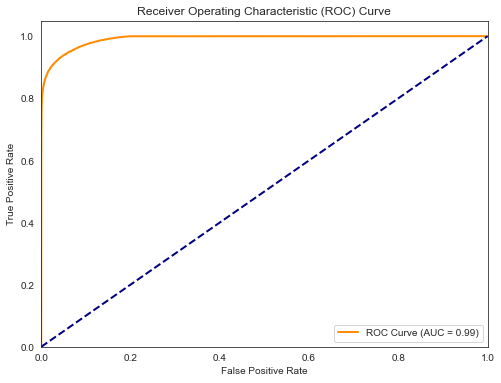

In [29]:
#Data visualization of LSTM model

# Calculating the ROC curve
fpr, tpr, _ = roc_curve(y, y_prob)

# Calculating the AUC (Area Under the Curve)
auc = roc_auc_score(y, y_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


This visualization of ROC curve graphically represents the model's performance across various thresholds for differentiating between positive and negative case.
<br>The steep increase in orange curve suggests that the model correctly identified a high proportion of true positives while allowing some false positives. The curve then eventually reaches 1.0,1.0 indicating that there is a threshold where all instances were positive. The value of AUC score is 0.99 implies that this model can easily differentiate between positive and negative cases and that this model is well performed.

## CNN using stratified K-Fold evaluation

In [31]:
#This is the main code for building the CNN model

#Setting seeds
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Defining the CNN model using multiple layers
def build_CNN_model(input_shape):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    cnn_model.add(MaxPooling1D(2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1, activation='sigmoid'))  # Binary classification, use 'sigmoid' activation
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn_model

# Initializing the Stratified K-Fold
n_splits = 3  
sk_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing results
classification_reports = []
accuracy_list = []

# Initializing an empty DataFrame that can store the classification reports
classification_report_data = pd.DataFrame()

# Performing the K-fold cross-validation
for fold, (train_index_value, test_index_value) in enumerate(sk_fold.split(X, y), 1):
    X_train, X_test = X[train_index_value], X[test_index_value]
    y_train, y_test = y[train_index_value], y[test_index_value]

    # Reshaping the input data for CNN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Standardizing features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Instantiating the model
    cnn_model = build_CNN_model(X_train[0].shape)

    # Fitting the model
    cnn_model.fit(X_train, y_train, epochs=100, batch_size=1000, verbose=2, validation_split=0.2)

    # Predicting class probabilities on the test data
    y_prob = cnn_model.predict(X_test)

    # Converting class probabilities to binary labels with threshold 0.5
    y_pred = (y_prob > 0.5).astype(int).flatten()

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    # Generating and storing the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)

    # Converting the classification report to a DataFrame and add it to the report_df
    classification_report_data[f'Fold {fold}'] = pd.Series(report['1'])  # For class '1'



Epoch 1/100
94/94 - 3s - loss: 0.4205 - accuracy: 0.8388 - val_loss: 0.1196 - val_accuracy: 0.9923 - 3s/epoch - 32ms/step
Epoch 2/100
94/94 - 2s - loss: 0.2554 - accuracy: 0.9065 - val_loss: 0.0882 - val_accuracy: 0.9953 - 2s/epoch - 20ms/step
Epoch 3/100
94/94 - 2s - loss: 0.2100 - accuracy: 0.9138 - val_loss: 0.0686 - val_accuracy: 0.9941 - 2s/epoch - 17ms/step
Epoch 4/100
94/94 - 2s - loss: 0.1888 - accuracy: 0.9186 - val_loss: 0.0487 - val_accuracy: 0.9965 - 2s/epoch - 20ms/step
Epoch 5/100
94/94 - 2s - loss: 0.1774 - accuracy: 0.9207 - val_loss: 0.0515 - val_accuracy: 0.9938 - 2s/epoch - 18ms/step
Epoch 6/100
94/94 - 2s - loss: 0.1706 - accuracy: 0.9218 - val_loss: 0.0446 - val_accuracy: 0.9942 - 2s/epoch - 19ms/step
Epoch 7/100
94/94 - 2s - loss: 0.1664 - accuracy: 0.9226 - val_loss: 0.0411 - val_accuracy: 0.9938 - 2s/epoch - 19ms/step
Epoch 8/100
94/94 - 2s - loss: 0.1635 - accuracy: 0.9228 - val_loss: 0.0426 - val_accuracy: 0.9925 - 2s/epoch - 19ms/step
Epoch 9/100
94/94 - 2s -

Epoch 68/100
94/94 - 2s - loss: 0.1418 - accuracy: 0.9325 - val_loss: 0.0299 - val_accuracy: 0.9920 - 2s/epoch - 20ms/step
Epoch 69/100
94/94 - 2s - loss: 0.1409 - accuracy: 0.9330 - val_loss: 0.0292 - val_accuracy: 0.9920 - 2s/epoch - 22ms/step
Epoch 70/100
94/94 - 2s - loss: 0.1407 - accuracy: 0.9335 - val_loss: 0.0349 - val_accuracy: 0.9890 - 2s/epoch - 19ms/step
Epoch 71/100
94/94 - 2s - loss: 0.1409 - accuracy: 0.9332 - val_loss: 0.0411 - val_accuracy: 0.9859 - 2s/epoch - 19ms/step
Epoch 72/100
94/94 - 2s - loss: 0.1412 - accuracy: 0.9333 - val_loss: 0.0332 - val_accuracy: 0.9896 - 2s/epoch - 19ms/step
Epoch 73/100
94/94 - 2s - loss: 0.1409 - accuracy: 0.9331 - val_loss: 0.0310 - val_accuracy: 0.9908 - 2s/epoch - 21ms/step
Epoch 74/100
94/94 - 2s - loss: 0.1406 - accuracy: 0.9335 - val_loss: 0.0299 - val_accuracy: 0.9915 - 2s/epoch - 22ms/step
Epoch 75/100
94/94 - 2s - loss: 0.1406 - accuracy: 0.9333 - val_loss: 0.0303 - val_accuracy: 0.9914 - 2s/epoch - 20ms/step
Epoch 76/100
94/

Epoch 35/100
94/94 - 2s - loss: 0.1461 - accuracy: 0.9298 - val_loss: 0.0398 - val_accuracy: 0.9881 - 2s/epoch - 18ms/step
Epoch 36/100
94/94 - 2s - loss: 0.1454 - accuracy: 0.9294 - val_loss: 0.0280 - val_accuracy: 0.9941 - 2s/epoch - 19ms/step
Epoch 37/100
94/94 - 2s - loss: 0.1454 - accuracy: 0.9296 - val_loss: 0.0293 - val_accuracy: 0.9930 - 2s/epoch - 19ms/step
Epoch 38/100
94/94 - 2s - loss: 0.1445 - accuracy: 0.9300 - val_loss: 0.0242 - val_accuracy: 0.9956 - 2s/epoch - 19ms/step
Epoch 39/100
94/94 - 2s - loss: 0.1447 - accuracy: 0.9299 - val_loss: 0.0232 - val_accuracy: 0.9961 - 2s/epoch - 18ms/step
Epoch 40/100
94/94 - 2s - loss: 0.1447 - accuracy: 0.9301 - val_loss: 0.0288 - val_accuracy: 0.9937 - 2s/epoch - 19ms/step
Epoch 41/100
94/94 - 2s - loss: 0.1442 - accuracy: 0.9308 - val_loss: 0.0324 - val_accuracy: 0.9915 - 2s/epoch - 24ms/step
Epoch 42/100
94/94 - 3s - loss: 0.1438 - accuracy: 0.9303 - val_loss: 0.0313 - val_accuracy: 0.9922 - 3s/epoch - 27ms/step
Epoch 43/100
94/

Epoch 2/100
94/94 - 2s - loss: 0.2526 - accuracy: 0.9066 - val_loss: 0.0861 - val_accuracy: 0.9951 - 2s/epoch - 24ms/step
Epoch 3/100
94/94 - 3s - loss: 0.2083 - accuracy: 0.9133 - val_loss: 0.0636 - val_accuracy: 0.9961 - 3s/epoch - 29ms/step
Epoch 4/100
94/94 - 2s - loss: 0.1888 - accuracy: 0.9177 - val_loss: 0.0521 - val_accuracy: 0.9956 - 2s/epoch - 24ms/step
Epoch 5/100
94/94 - 2s - loss: 0.1785 - accuracy: 0.9190 - val_loss: 0.0505 - val_accuracy: 0.9942 - 2s/epoch - 22ms/step
Epoch 6/100
94/94 - 2s - loss: 0.1721 - accuracy: 0.9198 - val_loss: 0.0430 - val_accuracy: 0.9945 - 2s/epoch - 22ms/step
Epoch 7/100
94/94 - 2s - loss: 0.1679 - accuracy: 0.9205 - val_loss: 0.0400 - val_accuracy: 0.9941 - 2s/epoch - 19ms/step
Epoch 8/100
94/94 - 2s - loss: 0.1647 - accuracy: 0.9212 - val_loss: 0.0351 - val_accuracy: 0.9949 - 2s/epoch - 19ms/step
Epoch 9/100
94/94 - 2s - loss: 0.1625 - accuracy: 0.9219 - val_loss: 0.0443 - val_accuracy: 0.9916 - 2s/epoch - 19ms/step
Epoch 10/100
94/94 - 2s 

Epoch 69/100
94/94 - 2s - loss: 0.1389 - accuracy: 0.9329 - val_loss: 0.0349 - val_accuracy: 0.9878 - 2s/epoch - 18ms/step
Epoch 70/100
94/94 - 2s - loss: 0.1391 - accuracy: 0.9328 - val_loss: 0.0386 - val_accuracy: 0.9850 - 2s/epoch - 19ms/step
Epoch 71/100
94/94 - 2s - loss: 0.1392 - accuracy: 0.9330 - val_loss: 0.0343 - val_accuracy: 0.9879 - 2s/epoch - 18ms/step
Epoch 72/100
94/94 - 2s - loss: 0.1390 - accuracy: 0.9335 - val_loss: 0.0299 - val_accuracy: 0.9912 - 2s/epoch - 19ms/step
Epoch 73/100
94/94 - 2s - loss: 0.1387 - accuracy: 0.9334 - val_loss: 0.0379 - val_accuracy: 0.9850 - 2s/epoch - 21ms/step
Epoch 74/100
94/94 - 2s - loss: 0.1389 - accuracy: 0.9330 - val_loss: 0.0272 - val_accuracy: 0.9931 - 2s/epoch - 19ms/step
Epoch 75/100
94/94 - 2s - loss: 0.1387 - accuracy: 0.9332 - val_loss: 0.0315 - val_accuracy: 0.9903 - 2s/epoch - 20ms/step
Epoch 76/100
94/94 - 2s - loss: 0.1385 - accuracy: 0.9330 - val_loss: 0.0266 - val_accuracy: 0.9934 - 2s/epoch - 19ms/step
Epoch 77/100
94/

In [33]:
#This is the code for printing the evaluation metrics of the CNN model

# Calculating and printing the average accuracy
avg_accuracy = np.mean(accuracy_list)
print("Average Accuracy of the CNN Model using cross validation is :", avg_accuracy)

# Print the classification reports in tabular form
print("Classification Report of the CNN Model is :\n", classification_report_data)


Average Accuracy of the CNN Model using cross validation is : 0.9436925761801289
Classification Report of the CNN Model is :
                  Fold 1        Fold 2        Fold 3
precision      0.940688      0.952158      0.942290
recall         0.976395      0.966591      0.978910
f1-score       0.958209      0.959320      0.960251
support    39780.000000  39780.000000  39781.000000


The evaluation metrics suggest that the accuracy of the CNN model is 94.3% which is better than the baseline model. For all the folds, the precision, recall and f1-score value is high indicating a well-performed model and effectiveness in the classification task. This classification resport is for class 1(abnormal) and these high values indicate that the model is able to correctly identify the abnormal network traffic therefore effectively carrying out network intrusion detection.  

## Conclusion

By comparing these models we can tell that LSTM achieved highest value of accuracy of 94.7% and therefore, is the best model implemented. With the help of these models we can easily perform network intrusion detection.